# Chapter 2 Pytorch 

In [2]:
import torch
torch.set_default_dtype(torch.float64)

import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

import torch.optim as optim

from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
plt.rcParams["figure.figsize"]=(10,7)

# comment out the below if don"t have a 4k or retina display
%config InlineBackend.figure_format="retina"

# Data 

In [7]:
egg_timing_df = pd.read_csv("egg_times.csv",index_col=0)
egg_timing_df.head(n=10)

,weight,time,outcome
0,55.0,7.1,2
1,55.2,2.8,0
2,59.2,5.1,2
3,47.3,2.1,0
4,62.9,6.8,2
5,51.0,3.0,0
6,58.6,6.4,2
7,52.4,1.5,0
8,55.3,4.6,2
9,56.5,4.8,1


In [17]:
max(egg_timing_df["weight"])

69.5

In [18]:
np.mean(egg_timing_df["weight"])

55.06291079812208

In [19]:
np.std(egg_timing_df["weight"])

5.0245517689382995

In [8]:
egg_timing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 0 to 638
Data columns (total 3 columns):
weight     639 non-null float64
time       639 non-null float64
outcome    639 non-null int64
dtypes: float64(2), int64(1)
memory usage: 20.0 KB


In [8]:
train_ = egg_timing_df[["weight","time"]].values # TensorFlow/Keras likes numpy/arrays rather than Dataframes
target_ = egg_timing_df["outcome"].values #.to_numpy()

train_in = train_[:-50] # get all except the last 50 for training
train_target = target_[:-50]

val_in = train_[-50:] # take all from the last 50 for validation
val_target = target_[-50:]

In [123]:
n = len(target_)
num_underdone = sum(target_==0)
print(num_underdone)
num_softboiled = sum(target_==1)
print(num_softboiled)
num_hardboiled = sum(target_==2)
print(num_hardboiled)

# class_weights = {0:underdone_class_weight, 1:softboiled_class_weight, 2: hardboiled_class_weight}

202
117
320


In [168]:
underdone = egg_timing_df[egg_timing_df["outcome"]==0][:117]
softboiled = egg_timing_df[egg_timing_df["outcome"]==1]
hardboiled = egg_timing_df[egg_timing_df["outcome"]==2][:117]

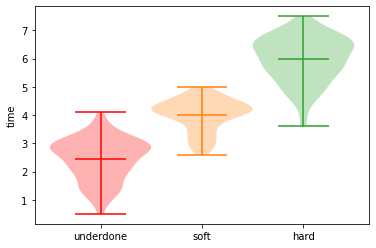

In [170]:
violin_parts = plt.violinplot(underdone['time'], positions=[0], showmeans=True)
# over-ride default blue color, you can't use 'color' parameter as can on histograms etc
for pc in violin_parts['bodies']: # used to
    pc.set_facecolor('red')
    violin_parts['cbars'].set_edgecolor('red')
    violin_parts['cmaxes'].set_edgecolor('red')
    violin_parts['cmins'].set_edgecolor('red')
    violin_parts['cmeans'].set_edgecolor('red')
    plt.violinplot(softboiled['time'], positions=[0.5], showmeans=True)
    plt.violinplot(hardboiled['time'], positions=[1], showmeans=True)
    plt.ylabel("time")
    plt.xticks([0,0.5,1],["underdone", "soft", "hard"])

In [69]:
len(train_)

639

In [9]:
class EggTimesDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, df):

        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        features = self.df.iloc[idx, :-1].values
        outcomes = np.array(self.df.iloc[idx, -1])

        example = {"features": features, "outcomes": outcomes}

        return example

train_dataset = EggTimesDataset(egg_timing_df[:-50])
test_dataset = EggTimesDataset(egg_timing_df[-50:])

In [7]:
train_dataset[0]

{'features': array([55. ,  7.1]), 'outcomes': array(2)}

In [10]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=50,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=50,
                                          shuffle=True, num_workers=2)

# Dense model

In [3]:
class DenseModel(nn.Module):
    def __init__(self, num_in):

        super(DenseModel, self).__init__()

        self.fc1 = nn.Linear(num_in, 16)
        self.fc2 = nn.Linear(16, 6)
        self.fc3 = nn.Linear(6, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dense = DenseModel(2)

### Setup for training

In [4]:
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense.parameters(), lr=learning_rate) # note this uses *Pytorch* optim not Pyro

### training loop 

In [65]:
for epoch in range(800): 

    running_loss = []
    for i, batch in enumerate(trainloader):
        
        inputs = batch["features"]
        labels = batch["outcomes"]

        optimizer.zero_grad()

        outputs = dense(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        freq_checks = 5
    if epoch % freq_checks == 0:
        print("epoch: {} loss: {:.3f}".format(epoch, sum(running_loss) / len(running_loss)))
        running_loss = []
        for data in testloader:
            test_inputs = data["features"]
            test_labels = data["outcomes"]
            outputs = dense(test_inputs)
            _, predicted = torch.max(outputs, 1)
            print("Test accuracy:", sum(np.array(predicted)==np.array(test_labels))/len(predicted))
print("Final loss:{:.3f} at epoch: {} and learning rate: {}".format(sum(running_loss)/len(running_loss),epoch,learning_rate))

epoch: 0 loss: 1.983
Test accuracy: 0.2
epoch: 5 loss: 0.951
Test accuracy: 0.38
epoch: 10 loss: 0.940
Test accuracy: 0.38
epoch: 15 loss: 0.921
Test accuracy: 0.38
epoch: 20 loss: 0.906
Test accuracy: 0.42
epoch: 25 loss: 0.880
Test accuracy: 0.44
epoch: 30 loss: 0.857
Test accuracy: 0.54
epoch: 35 loss: 0.832
Test accuracy: 0.56
epoch: 40 loss: 0.804
Test accuracy: 0.6
epoch: 45 loss: 0.773
Test accuracy: 0.76
epoch: 50 loss: 0.737
Test accuracy: 0.76
epoch: 55 loss: 0.709
Test accuracy: 0.76
epoch: 60 loss: 0.676
Test accuracy: 0.78
epoch: 65 loss: 0.644
Test accuracy: 0.78
epoch: 70 loss: 0.618
Test accuracy: 0.8
epoch: 75 loss: 0.591
Test accuracy: 0.8
epoch: 80 loss: 0.566
Test accuracy: 0.8
epoch: 85 loss: 0.543
Test accuracy: 0.8
epoch: 90 loss: 0.520
Test accuracy: 0.8
epoch: 95 loss: 0.500
Test accuracy: 0.8
epoch: 100 loss: 0.482
Test accuracy: 0.8
epoch: 105 loss: 0.464
Test accuracy: 0.8
epoch: 110 loss: 0.453
Test accuracy: 0.8
epoch: 115 loss: 0.434
Test accuracy: 0.8
ep

# Pyro model

In [53]:
def model(data):
    fc1w_prior = dist.Normal(loc=torch.zeros_like(dense.fc1.weight), scale=torch.ones_like(dense.fc1.weight))
    fc1b_prior = dist.Normal(loc=torch.zeros_like(dense.fc1.bias), scale=torch.ones_like(dense.fc1.bias))
    
    fc2w_prior = dist.Normal(loc=torch.zeros_like(dense.fc2.weight), scale=torch.ones_like(dense.fc2.weight))
    fc2b_prior = dist.Normal(loc=torch.zeros_like(dense.fc2.bias), scale=torch.ones_like(dense.fc2.bias))
    
    fc3w_prior = dist.Normal(loc=torch.zeros_like(dense.fc3.weight), scale=torch.ones_like(dense.fc3.weight))
    fc3b_prior = dist.Normal(loc=torch.zeros_like(dense.fc3.bias), scale=torch.ones_like(dense.fc3.bias))
    
    priors = {"fc1w": fc1w_prior, "fc1b": fc1b_prior, "fc2w":fc2w_prior, "fc2b":fc2b_prior,  "fc3w": fc3w_prior, "fc3b": fc3b_prior}

    lifted_module = pyro.random_module("module", dense, priors)
    lifted_reg_model = lifted_module()
    
    probs = torch.nn.functional.log_softmax(lifted_reg_model(data["features"]),dim=1)
    
    pyro.sample("obs", dist.Categorical(logits=probs), obs=data["outcomes"])

In [54]:
def guide(data):
    
    # FC1 weights
    fc1w_mu = torch.randn_like(dense.fc1.weight)
    fc1w_sigma = torch.randn_like(dense.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = F.softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_approx_post = dist.Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # FC1 bias
    fc1b_mu = torch.randn_like(dense.fc1.bias)
    fc1b_sigma = torch.randn_like(dense.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = F.softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_approx_post = dist.Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
    # FC2 weights
    fc2w_mu = torch.randn_like(dense.fc2.weight)
    fc2w_sigma = torch.randn_like(dense.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = F.softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2w_approx_post = dist.Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
    # FC2 bias
    fc2b_mu = torch.randn_like(dense.fc2.bias)
    fc2b_sigma = torch.randn_like(dense.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = F.softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2b_approx_post = dist.Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
    
    # FC3 weights
    fc3w_mu = torch.randn_like(dense.fc3.weight)
    fc3w_sigma = torch.randn_like(dense.fc3.weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = F.softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3w_approx_post = dist.Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param).independent(1)
    # FC3 bias
    fc3b_mu = torch.randn_like(dense.fc3.bias)
    fc3b_sigma = torch.randn_like(dense.fc3.bias)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = F.softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3b_approx_post = dist.Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)
#     priors = {"fc1w": fc1w_approx_post, "fc1b": fc1b_approx_post, "fc2.weight":fc2w_approx_post, "fc2.bias":fc2b_approx_post,  "fc3w": fc3w_approx_post, "fc3b": fc3b_approx_post}
    approx_posterior = {"fc1w": fc1w_approx_post, "fc1b": fc1b_approx_post, "fc2w":fc2w_approx_post, "fc2b":fc2b_approx_post,  "fc3w": fc3w_approx_post, "fc3b": fc3b_approx_post}

    lifted_module = pyro.random_module("module", dense, approx_posterior)
    
    return lifted_module()

In [55]:
optim = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [16]:
num_iterations = 50
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(trainloader):
        # calculate the loss and take a gradient step
        loss += svi.step(data)
    normalizer_train = len(trainloader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  0.5759480532048973


/home/ubuntu/.local/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  1  Loss  0.4308028729966467
Epoch  2  Loss  0.2907571832342086
Epoch  3  Loss  0.2576778024488472
Epoch  4  Loss  0.19866088971592857
Epoch  5  Loss  0.18886162833062217
Epoch  6  Loss  0.1887337509417171
Epoch  7  Loss  0.18801478422293746
Epoch  8  Loss  0.1996707081349443
Epoch  9  Loss  0.18544403473938173
Epoch  10  Loss  0.19112577635733408
Epoch  11  Loss  0.2074123435922001
Epoch  12  Loss  0.20213966046853227
Epoch  13  Loss  0.1973001002822812
Epoch  14  Loss  0.19320969753494818
Epoch  15  Loss  0.2023257077742067
Epoch  16  Loss  0.19843402616380448
Epoch  17  Loss  0.20402066751490408
Epoch  18  Loss  0.20274055832674398
Epoch  19  Loss  0.20962198453546185
Epoch  20  Loss  0.21068258657818303
Epoch  21  Loss  0.20850706719054884
Epoch  22  Loss  0.21469199395602742
Epoch  23  Loss  0.20414196829867154
Epoch  24  Loss  0.2266960006713157
Epoch  25  Loss  0.2003526754551905
Epoch  26  Loss  0.19793699200767004
Epoch  27  Loss  0.1836505532732002
Epoch  28  Loss  0.20

# Analysis

(array([4614.,  386.,    0.]),
 array([0, 1, 2, 3]),
 <a list of 3 Patch objects>)

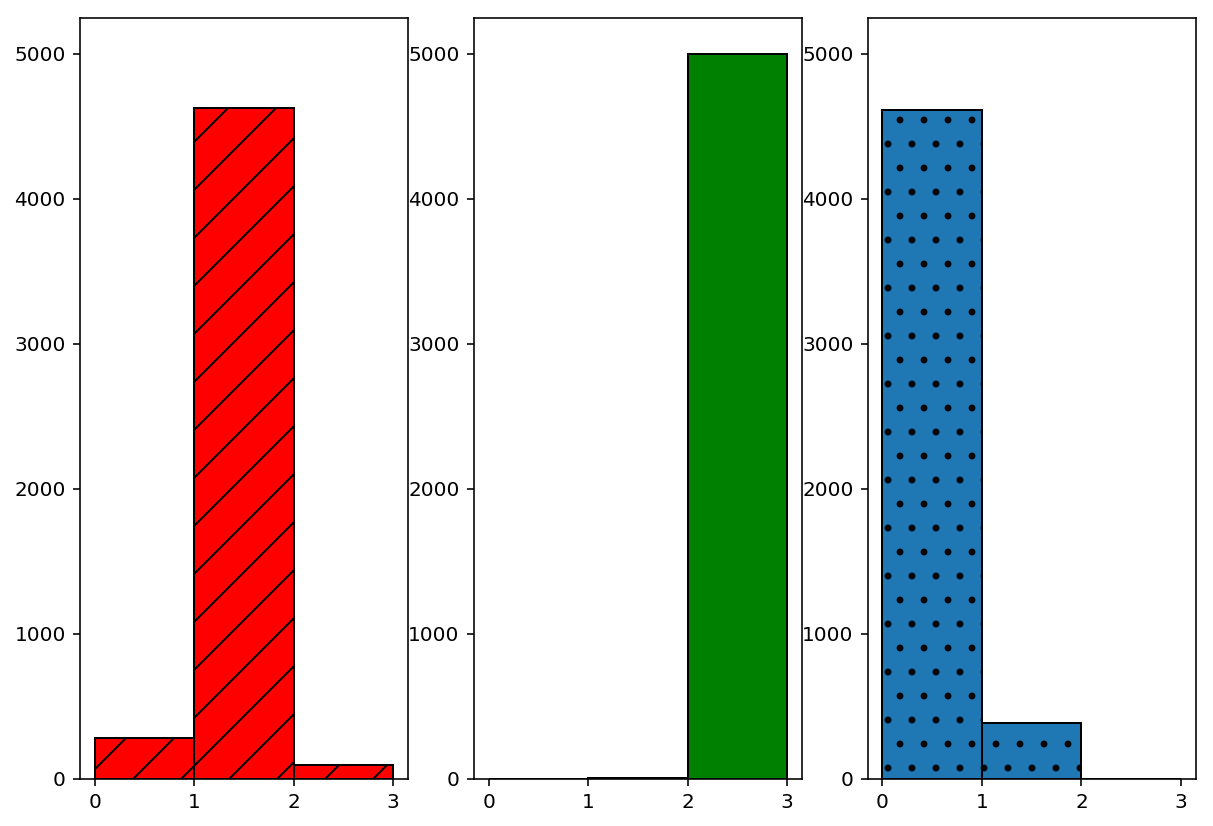

In [384]:
ax1 = plt.subplot(1,3,1)
ax1.hist(predicted[:,1].reshape(-1,1),bins=[0,1,2,3],density=False, hatch="/", color='r', edgecolor='black')
ax = plt.subplot(1,3,2, sharey=ax1)
ax.hist(predicted[:,49].reshape(-1,1),bins=[0,1,2,3],density=False, color='g', edgecolor='black')
ax = plt.subplot(1,3,3,sharey=ax1)
ax.hist(predicted[:,13].reshape(-1,1),bins=[0,1,2,3],density=False, hatch=".", edgecolor='black')

In [115]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

fc1w_mu tensor([[ 0.1230, -0.8274],
        [ 1.0778,  1.3515],
        [-0.4878, -0.4072],
        [ 1.0617,  1.3786],
        [-2.1414, -0.1784],
        [-0.4373, -0.9054]], requires_grad=True)
fc1w_sigma tensor([[-1.1695,  0.7637],
        [-0.1601, -0.1941],
        [ 2.0116,  1.6407],
        [ 0.0570, -0.1494],
        [-0.1442,  0.6626],
        [ 1.6812, -0.6774]], requires_grad=True)
fc1b_mu tensor([ 0.2829, -0.3415,  0.2397,  0.4814, -0.6288, -0.0053],
       requires_grad=True)
fc1b_sigma tensor([-0.4504,  1.9364,  0.8772,  0.7990,  0.1504,  2.3177],
       requires_grad=True)
fc2w_mu tensor([[-1.6115, -1.2755, -0.4039,  1.1034,  0.1217,  1.0527],
        [-1.7369,  0.4661, -0.2442, -1.3091, -0.1219,  0.5382],
        [ 0.3656,  0.4112, -0.4480,  0.9244,  1.6293, -0.3408]],
       requires_grad=True)
fc2w_sigma tensor([[-0.3321,  0.9264, -1.2815,  2.0341, -0.0729, -0.2468],
        [-0.3096, -0.2147, -0.3156, -0.1335,  0.8371,  0.4430],
        [ 0.0404,  0.8403,  1.8279, -

In [174]:
num_samples = 10
def predict(data):
    sampled_models = [guide(None) for _ in range(num_samples)]
    predictions = [m(data).data for m in sampled_models]
    mean = torch.mean(torch.stack(predictions), 0)
    return np.argmax(mean.numpy(), axis=1)

In [180]:
correct = 0
total = 0
for j, data in enumerate(testloader):
    features = data["features"]
    labels = data["outcomes"]
    predicted = predict(features)
    total += labels.size(0)
    correct += (np.array(predicted) == np.array(labels)).sum().item()
print("accuracy: {:.2f}".format(100 * correct / total))

accuracy: 88.00
